In [59]:
%load_ext notexbook
%texify

# Introducing `torchdata.DataPipe`

In [1]:
import torch as th
from torch.utils.data import Dataset, DataLoader

In [2]:
SCRYFALL_DEFAULT_CARDS_URL = (
    "https://data.scryfall.io/default-cards/default-cards-20221103090502.json"
)

In [3]:
from functools import partial
import os 

def path_fn(root: str, file_url: str) -> str:
    return os.path.join(root, os.path.basename(file_url))

DATA_FOLDER = os.path.join(os.path.abspath(os.path.curdir), "data")

### Data Abstractions

In [4]:
from collections import namedtuple
from dataclasses import dataclass
from enum import Enum


CardImagery = namedtuple(
    "CardImagery", ["border_crop", "art_crop", "large", "normal", "small"]
)

class Color(Enum):
    W = 1
    U = 2
    B = 3
    R = 4
    G = 5

@dataclass
class Card:
    cid: str
    name: str 
    lang: str 
    set_code: str
    set_name: str
    set_type: str
    artist: str
    frame: str
    legalities: dict
    color_identity: list[Color] = None
    art: CardImagery = None
    
    

In [5]:
from torchdata.datapipes import functional_datapipe
from torchdata.datapipes.iter import IterDataPipe
from typing import Iterator

@functional_datapipe("parse_mtg_cards")
class CardParserIterDataPipe(IterDataPipe):
    def __init__(self, dp: IterDataPipe) -> None:
        self._source_dp = dp

    def __iter__(self) -> Iterator[tuple[int, Card]]:
        for _, db in self._source_dp:
            for entry in db:
                if entry["lang"] != "en":
                    continue
                if (
                    entry["games"]
                    and len(entry["games"]) == 1
                    and entry["games"][0] == "mtgo"
                ):
                    continue  # skip Online-only Expansion Promo Sets
                if "image_uris" in entry:
                    card_imagery = CardImagery(
                        border_crop=entry["image_uris"]["border_crop"],
                        art_crop=entry["image_uris"]["art_crop"],
                        large=entry["image_uris"]["large"],
                        normal=entry["image_uris"]["normal"],
                        small=entry["image_uris"]["small"],
                    )
                else:
                    card_imagery = None
                
                if "color_identity" in entry:
                    color_identity = [Color[v.upper()].value for v in entry["color_identity"]]
                else:
                    color_identity = None
                
                card = Card(
                    cid=entry["id"],
                    name=entry["name"],
                    lang=entry["lang"],
                    set_code=entry["set"],
                    set_name=entry["set_name"],
                    set_type=entry["set_type"],
                    art=card_imagery,
                    artist=entry["artist"],
                    frame=entry["frame"],
                    legalities=entry["legalities"],
                    color_identity=color_identity
                )
                yield card
                
                

**OOP-style `DataPipe`**

```python
from torchdata.datapipes.iter import IterableWrapper
from torchdata.datapipes.iter import FileOpener, JsonParser, HttpReader
from torchdata.datapipes.iter import OnDiskCacheHolder, EndOnDiskCacheHolder

cards = IterableWrapper([SCRYFALL_DEFAULT_CARDS_URL])
cards = OnDiskCacheHolder(cards, filepath_fn = partial(path_fn, DATA_FOLDER))
cards = HttpReader(cards)
cards = EndOnDiskCacheHolder(cards, mode="wb", same_filepath_fn=True)
cards = FileOpener(cards, mode="b")
cards = JsonParser(cards)
cards = CardParserIterDataPipe(cards)
```

In [6]:
from torchdata.datapipes.iter import IterableWrapper
from torchdata.datapipes.iter import FileOpener, JsonParser, HttpReader
from torchdata.datapipes.iter import OnDiskCacheHolder, EndOnDiskCacheHolder

cards = IterableWrapper([SCRYFALL_DEFAULT_CARDS_URL])
cards = OnDiskCacheHolder(cards, filepath_fn = partial(path_fn, DATA_FOLDER))
cards = HttpReader(cards)
cards = EndOnDiskCacheHolder(cards, mode="wb", same_filepath_fn=True)
cards = FileOpener(cards, mode="b")
cards = JsonParser(cards)
cards = CardParserIterDataPipe(cards)

**functional-style `DataPipe`**

```python
cards = (
    IterableWrapper([SCRYFALL_DEFAULT_CARDS_URL])
    .on_disk_cache(filepath_fn=partial(path_fn, DATA_FOLDER))
    .read_from_http()
    .end_caching(mode="wb", same_filepath_fn=True)
    .open_files(mode="b")
    .parse_json_files()
    .parse_mtg_cards()
)
```

In [7]:
cards = (
    IterableWrapper([SCRYFALL_DEFAULT_CARDS_URL])
    .on_disk_cache(filepath_fn=partial(path_fn, DATA_FOLDER))
    .read_from_http()
    .end_caching(mode="wb", same_filepath_fn=True)
    .open_files(mode="b")
    .parse_json_files()
    .parse_mtg_cards()
)

In [8]:
iter_cards = iter(cards)
next(iter_cards)

Card(cid='0000579f-7b35-4ed3-b44c-db2a538066fe', name='Fury Sliver', lang='en', set_code='tsp', set_name='Time Spiral', set_type='expansion', artist='Paolo Parente', frame='2003', legalities={'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'not_legal', 'vintage': 'legal', 'penny': 'legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'restricted', 'duel': 'legal', 'oldschool': 'not_legal', 'premodern': 'not_legal'}, color_identity=[4], art=CardImagery(border_crop='https://cards.scryfall.io/border_crop/front/0/0/0000579f-7b35-4ed3-b44c-db2a538066fe.jpg?1562894979', art_crop='https://cards.scryfall.io/art_crop/front/0/0/0000579f-7b35-4ed3-b44c-db2a538066fe.jpg?1562894979', large='https://cards.scryfall.io/large/front/0/0/0000579f-7b35-4ed3-b44c-db2a538066fe.jpg?1562894979

## Filtering

In [9]:
# Premodern Cards
def premodern_legal_filter(card: Card) -> bool:
    return card.legalities["premodern"] == "legal"

# Modern Cards
def modern_legal_filter(card: Card) -> bool:
    return card.legalities["modern"] == "legal"

premodern_cards = cards.filter(premodern_legal_filter)
modern_cards = cards.filter(modern_legal_filter)

In [10]:
card = next(iter(premodern_cards))
card

Card(cid='00012bd8-ed68-4978-a22d-f450c8a6e048', name='Web', lang='en', set_code='3ed', set_name='Revised Edition', set_type='core', artist='Rob Alexander', frame='1993', legalities={'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'not_legal', 'vintage': 'legal', 'penny': 'legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'not_legal', 'duel': 'legal', 'oldschool': 'legal', 'premodern': 'legal'}, color_identity=[5], art=CardImagery(border_crop='https://cards.scryfall.io/border_crop/front/0/0/00012bd8-ed68-4978-a22d-f450c8a6e048.jpg?1559596693', art_crop='https://cards.scryfall.io/art_crop/front/0/0/00012bd8-ed68-4978-a22d-f450c8a6e048.jpg?1559596693', large='https://cards.scryfall.io/large/front/0/0/00012bd8-ed68-4978-a22d-f450c8a6e048.jpg?1559596693', normal='https:/

In [11]:
from IPython.display import display, Image

In [13]:
Image(url=card.art.small)

In [14]:
mod_card = next(iter(modern_cards))
mod_card

Card(cid='0000579f-7b35-4ed3-b44c-db2a538066fe', name='Fury Sliver', lang='en', set_code='tsp', set_name='Time Spiral', set_type='expansion', artist='Paolo Parente', frame='2003', legalities={'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'not_legal', 'vintage': 'legal', 'penny': 'legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'restricted', 'duel': 'legal', 'oldschool': 'not_legal', 'premodern': 'not_legal'}, color_identity=[4], art=CardImagery(border_crop='https://cards.scryfall.io/border_crop/front/0/0/0000579f-7b35-4ed3-b44c-db2a538066fe.jpg?1562894979', art_crop='https://cards.scryfall.io/art_crop/front/0/0/0000579f-7b35-4ed3-b44c-db2a538066fe.jpg?1562894979', large='https://cards.scryfall.io/large/front/0/0/0000579f-7b35-4ed3-b44c-db2a538066fe.jpg?1562894979

In [15]:
Image(url=mod_card.art.small)

Another example of _filter_ function: retaining all cards that have only one colour (e.g. for color prediction or classification, from images)

```python
## Filter Singol Colour Identity
def single_color_cards_filter(card: Card) -> bool:
    return len(card.color_identity) == 1

premodern_cards = premodern_cards.filter(single_color_cards_filter)
```

## Exercise

Define **two** new filtering function, named `ice_age_filter` and `mirrodin_filter`, respectively, that will have the purpose to retain in the collection only cards 
from their corresponding sets, namely _Ice Age_ and _Mirrodin_.

**Hint**: To filter the cards in the DB, please use:
- `card.set_code==ice` for Ice Age expansion set;
- `card.set_code==mrd` for Mirrodin set.

In [16]:
def iceage_filter(card: Card) -> bool:
    return card.set_code.lower() == "ice"

def mirrodin_filter(card: Card) -> bool:
    return card.set_code.lower() == "mrd"

iceage_cards = premodern_cards.filter(iceage_filter)
mirrodin_cards = premodern_cards.filter(mirrodin_filter)

In [17]:
ia_card = next(iter(iceage_cards))

In [18]:
ia_card

Card(cid='00ae906b-2c4d-48e9-9f2d-217777e22292', name='Thermokarst', lang='en', set_code='ice', set_name='Ice Age', set_type='expansion', artist='Ken Meyer, Jr.', frame='1993', legalities={'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'not_legal', 'legacy': 'legal', 'pauper': 'legal', 'vintage': 'legal', 'penny': 'not_legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'legal', 'duel': 'legal', 'oldschool': 'not_legal', 'premodern': 'legal'}, color_identity=[5], art=CardImagery(border_crop='https://cards.scryfall.io/border_crop/front/0/0/00ae906b-2c4d-48e9-9f2d-217777e22292.jpg?1562895150', art_crop='https://cards.scryfall.io/art_crop/front/0/0/00ae906b-2c4d-48e9-9f2d-217777e22292.jpg?1562895150', large='https://cards.scryfall.io/large/front/0/0/00ae906b-2c4d-48e9-9f2d-217777e22292.jpg?1562895150', norma

In [19]:
Image(url=ia_card.art.small)

In [20]:
mrd_card = next(iter(mirrodin_cards))
mrd_card

Card(cid='018dcb37-221a-4552-9e72-2b9492883eae', name='Bottle Gnomes', lang='en', set_code='mrd', set_name='Mirrodin', set_type='expansion', artist='Ben Thompson', frame='2003', legalities={'standard': 'not_legal', 'future': 'not_legal', 'historic': 'not_legal', 'gladiator': 'not_legal', 'pioneer': 'not_legal', 'explorer': 'not_legal', 'modern': 'legal', 'legacy': 'legal', 'pauper': 'legal', 'vintage': 'legal', 'penny': 'legal', 'commander': 'legal', 'brawl': 'not_legal', 'historicbrawl': 'not_legal', 'alchemy': 'not_legal', 'paupercommander': 'legal', 'duel': 'legal', 'oldschool': 'not_legal', 'premodern': 'legal'}, color_identity=[], art=CardImagery(border_crop='https://cards.scryfall.io/border_crop/front/0/1/018dcb37-221a-4552-9e72-2b9492883eae.jpg?1562134152', art_crop='https://cards.scryfall.io/art_crop/front/0/1/018dcb37-221a-4552-9e72-2b9492883eae.jpg?1562134152', large='https://cards.scryfall.io/large/front/0/1/018dcb37-221a-4552-9e72-2b9492883eae.jpg?1562134152', normal='https

In [22]:
Image(url=mrd_card.art.small)

#### Converting to `MapStyle` DataPipe

Now let's define two functions to convert a single `Card` data object in the stream into something that becomes meaningful for a Machine Learning pipeline (i.e. training and/or evaluation pipeline).

In particular, we will define a function to generate the **features**, and another function to generate the **labels** for our learning problem! 

> 💡 It is very important to emphasise how this _functional_ approach to (composable) Data pipelines allows for easy modifications and less boilerplate code (e.g. changing either the _feature_ or the _labeling_ functions) without affecting the whole data pipelien!

Let's make an example to understand better.

### The learning problem

Create a classifier that is able to distinguish **old-fram** cards from **new-frame** cards. 

For simplicity and without any loss of generality we will leverage on our two `datapipes` namely `iceage_cards` and `mirrodin_cards` as representatives for the two classes (**old-frame** and **new-frame**, respectively).

Therefore, in order to have our dataset ready to be processed in 

In [27]:
# of course, we would like to return a Tensor
from typing import TypeVar
Tensor = TypeVar("Tensor")

In [28]:
import requests
from io import BytesIO
from PIL import Image as PILImage

from pathlib import Path
from torchvision.transforms import PILToTensor

transform = PILToTensor()

CARDS_FOLDER = Path(DATA_FOLDER) / "cards"
os.makedirs(CARDS_FOLDER, exist_ok=True)

def card_art_features(card: Card) -> str:
    url = card.art.small
    os.makedirs(CARDS_FOLDER / card.set_code.lower(), exist_ok=True)
    
    card_uri = f"{CARDS_FOLDER / card.set_code.lower() / card.name.replace(' ', '-').lower()}.jpg"
    if not os.path.exists(card_uri):
        response = requests.get(url)
        img = PILImage.open(BytesIO(response.content))
        img.save(card_uri)
    else:
        img = PILImage.open(card_uri)
    return transform(img)

In [29]:
def frame_label(card: Card) -> int:
    if card.set_code == "ice":
        return 0
    return 1

In [55]:
# concatenate, enumerate, and transform into a Map-Style Datapipe
from typing import Callable 
FeatureFn = Callable[[Card], Tensor]
LabelFn = Callable[[Card], int]

def sample_fn(card: Card, feature_fn: FeatureFn, label_fn: LabelFn):
    return feature_fn(card), label_fn(card)
sample_fn = partial(sample_fn, feature_fn=card_art_features, label_fn=frame_label)

def key_value_map_fn(card: Card, sample_fn) -> tuple[int, Tensor]:
    return sample_fn(card)

# plugin our sample function
key_value_fn = partial(key_value_map_fn, sample_fn=sample_fn)

all_cards = iceage_cards.concat(mirrodin_cards).map(fn=key_value_fn)

In [56]:
info = next(iter(all_cards))
info

(tensor([[[255, 248, 255,  ..., 245, 255, 244],
          [252, 255,  68,  ...,  89, 232, 255],
          [255,  72,   1,  ...,   0,  86, 247],
          ...,
          [255,  55,  11,  ...,   9, 105, 242],
          [248, 254,  83,  ...,  80, 221, 255],
          [250, 255, 246,  ..., 253, 255, 255]],
 
         [[253, 243, 253,  ..., 245, 255, 244],
          [250, 253,  63,  ...,  89, 232, 255],
          [254,  70,   0,  ...,   0,  86, 247],
          ...,
          [255,  55,  11,  ...,   4, 105, 242],
          [248, 254,  83,  ...,  75, 221, 255],
          [251, 255, 246,  ..., 251, 255, 255]],
 
         [[255, 249, 255,  ..., 247, 255, 244],
          [255, 255,  69,  ...,  91, 232, 255],
          [255,  73,   2,  ...,   2,  86, 247],
          ...,
          [255,  57,  13,  ...,  10, 105, 242],
          [248, 254,  83,  ...,  79, 221, 255],
          [246, 253, 244,  ..., 252, 255, 255]]], dtype=torch.uint8),
 0)

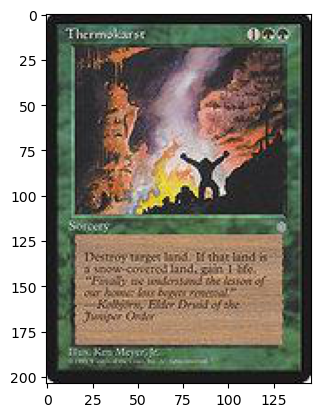

In [63]:
plt.imshow(info[0].numpy().transpose((1, 2, 0)))
plt.show()

In [51]:
for info in all_cards:
    print(idx, card.name, card.set_name)
    if idx > 10:
        break

0 Thermokarst Ice Age
1 Elvish Healer Ice Age
2 Gorilla Pack Ice Age
3 Fyndhorn Brownie Ice Age
4 Nacre Talisman Ice Age
5 Glacial Wall Ice Age
6 Game of Chaos Ice Age
7 Snow Hound Ice Age
8 Gangrenous Zombies Ice Age
9 Time Bomb Ice Age
10 Adarkar Wastes Ice Age
11 Bone Shaman Ice Age


In [28]:
mirrodin_cards_map = mirrodin_cards.to_map_datapipe(key_value_fn=partial(key_value_fn, 
                                                                         sample_label_fn=encode_label_fn))